In [1]:
import os
import re

import torch
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_milvus.vectorstores import Milvus
from langgraph.graph import START, StateGraph
from pydantic import BaseModel, Field
from thefuzz import fuzz, process
from typing_extensions import List, TypedDict

In [2]:
load_dotenv()

True

## Connect to Vector Database

In [3]:
# Utilize GPU to load and infer the embedding model if available 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We will use bge-m3 model to generate the dense vectors/ embeddings
EMBEDDING_MODEL_NAME = "jinaai/jina-embeddings-v3"

# This is the parameter to connect to the Zilliz vector database
ZILLIZ_URI = os.getenv("ZILLIZ_URI")
ZILLIZ_USER = os.getenv("ZILLIZ_USER")
ZILLIZ_PASSWORD = os.getenv("ZILLIZ_PASSWORD")
COLLECTION_NAME = "emgt_605_jina"

# Enable the tracing feature of Langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [4]:
def load_retriever(embedding_function, zilliz_uri, zilliz_user, zilliz_password, collection_name):
    vector_store = Milvus(
    embedding_function=[embedding_function],
    connection_args={
        "uri": zilliz_uri,
        "user": zilliz_user,
        "password": zilliz_password,
        "secure": True},
    collection_name=collection_name)
    
    return vector_store.as_retriever()

In [5]:
model_kwargs = {"device": DEVICE, "trust_remote_code":True}
dense_embeddings = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME, model_kwargs=model_kwargs)

c:\Users\Marselo\OneDrive\Documents\GitHub\uconline_poc\proj.venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Loading the vector database retriever.

In [6]:
retriever = load_retriever(dense_embeddings, ZILLIZ_URI, ZILLIZ_USER, 
                        ZILLIZ_PASSWORD, COLLECTION_NAME)

## Initialize LLM

In [7]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

llm = ChatGroq(api_key=GROQ_API_KEY, model="llama-3.3-70b-versatile", temperature=0, max_retries=3)

## Initialize Reranker

In [8]:
# from fastembed import LateInteractionTextEmbedding

In [9]:
# answerai_colbert = LateInteractionTextEmbedding(model_name="answerdotai/answerai-colbert-small-v1")

In [10]:
# import numpy as np


# def compute_relevance_scores(query_embedding: np.array, document_embeddings: np.array, k: int):
#     """
#     Compute relevance scores for top-k documents given a query.

#     :param query_embedding: Numpy array representing the query embedding, shape: [num_query_terms, embedding_dim]
#     :param document_embeddings: Numpy array representing embeddings for documents, shape: [num_documents, max_doc_length, embedding_dim]
#     :param k: Number of top documents to return
#     :return: Indices of the top-k documents based on their relevance scores
#     """
#     # Compute batch dot-product of query_embedding and document_embeddings
#     # Resulting shape: [num_documents, num_query_terms, max_doc_length]
#     scores = np.matmul(query_embedding, document_embeddings.transpose(0, 2, 1))

#     # Apply max-pooling across document terms (axis=2) to find the max similarity per query term
#     # Shape after max-pool: [num_documents, num_query_terms]
#     max_scores_per_query_term = np.max(scores, axis=2)

#     # Sum the scores across query terms to get the total score for each document
#     # Shape after sum: [num_documents]
#     total_scores = np.sum(max_scores_per_query_term, axis=1)

#     # Sort the documents based on their total scores and get the indices of the top-k documents
#     sorted_indices = np.argsort(total_scores)[::-1][:k]

#     return sorted_indices

In [11]:
# def rerank_docs_query(model, docs, query):
#     document_embeddings = list(model.embed(docs))
#     query_embeddings = list(model.embed([query]))
    
#     sorted_indices = compute_relevance_scores(
#     np.array(query_embeddings[0]), np.array(document_embeddings), k=3)
#     return [docs[i] for i in sorted_indices]

## Prompt and Flow Testing

We will test several patterns for the RAG system. Sources are defined as the context retrieved from the vector database while quotes are a specific span of the source that is used to formulate the final answer.

CitationProcessor class will be used to check the match between the sources and quotes, and generate the citation for the final answer which will redirect to the lesson blocks of the submodule page.

In [8]:
class CitationProcessor:
    def __init__(self, context, citations):
        """
        Initialize the CitationProcessor with the result object.
        """
        self.context = context
        self.citations = citations
        self.detailed_sources = []
        self.unique_final_urls = []

    @staticmethod
    def _search_substring_match(paragraph, substring, threshold=90):
        """
        Search for the best match of a substring in a paragraph using fuzzy matching.
        Returns the best match, its score, and its start and end character indices in the paragraph.
        """
        # Find the best match using a sliding window and process.extractOne
        substring_length = len(substring)
        sliding_para_windows = (paragraph[i:i + substring_length] for i in range(len(paragraph) - substring_length + 1))
        best_match, score = process.extractOne(substring, sliding_para_windows, scorer=fuzz.partial_ratio)

        # If the score meets the threshold, find start and end indices
        if score >= threshold:
            start_index = paragraph.find(best_match)
            end_index = start_index + len(best_match)
            return best_match, score, start_index, end_index
        else:
            return None, score, None, None
    
    @staticmethod
    def _extract_data_block_ids(data_block_ranges, start_index, end_index):
        """
        Extract the IDs of the data blocks that overlap with the provided range.
        """
        # List to hold the IDs of matching data blocks
        overlapping_ids = []

        # Iterate through each data block in the ranges
        for data_block_id, range_values in data_block_ranges.items():
            # Get the start and end values of the current data block
            block_start = range_values['char_start']
            block_end = range_values['char_end']
            
            # Check if the provided range overlaps with the current data block
            if start_index <= block_end and end_index >= block_start:
                overlapping_ids.append(data_block_id)
        
        return overlapping_ids  
    
    def _process_citation(self, citation):
        """
        Process a single citation to extract detailed source information.
        """
        context = self.context[citation.source_id]
        prefix, page_content = context.page_content.split("\n\n", 1)
        
        best_match, score, start_index, end_index = self._search_substring_match(page_content, citation.quote)
        
        if start_index and end_index:
            adjusted_start_index = context.metadata['start_index'] + start_index
            adjusted_end_index = context.metadata['start_index'] + end_index
            data_block_ids = self._extract_data_block_ids(context.metadata['data_block_ranges'], adjusted_start_index, adjusted_end_index)
        else:
            data_block_ids = []
            
        return {"submodule_url": context.metadata['submodule_url'], "data_block_ids": data_block_ids,
                "best_match": best_match, "score": score}
    
    @staticmethod
    def _generate_urls(submodule_url, data_block_ids):
        """Generate the final URLs by combining the submodule URL with the data blocks."""
        final_urls = []

        for data_block_id in set(data_block_ids):
            final_urls.append(submodule_url + f"/block/{data_block_id}")
            
        return final_urls
            
    def _add_unique_final_urls(self, final_urls):
        """
        Add final URLs to the unique_final_urls list if they don't already exist.
        """
        for final_url in final_urls:
            if final_url not in self.unique_final_urls:
                self.unique_final_urls.append(final_url)
    
    def process_citations(self):
        """
        Process all citations in the result to extract detailed sources and final unique URLs.
        """
        for citation in self.citations:
            detailed_source = self._process_citation(citation)
            if detailed_source:
                final_urls = self._generate_urls(detailed_source['submodule_url'], detailed_source['data_block_ids'])
                self._add_unique_final_urls(final_urls)
                detailed_source['final_url_ids'] = [self.unique_final_urls.index(final_url) for final_url in final_urls]
                self.detailed_sources.append(detailed_source)
        
        return {"detailed_sources": self.detailed_sources, "final_urls_dict": {i: url for i, url in enumerate(self.unique_final_urls)}}


#### Pattern 1: Answer with list of quotes

In [9]:
COURSE_NAME = "Sustainability Systems in Engineering"

generate_system_prompt = f"""You're a helpful personalized tutor for {COURSE_NAME}. Given a user question and some course contents, answer the question and justify your answer by providing verbatim citations from the course contents. If none of the course content answer the question, just say: "Sorry, I can't find any relevant course content related to your question.".

Here are the course contents:
{{sources}}"""

generate_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", generate_system_prompt),
        ("human", "{question}"),
    ]
)
generate_prompt.pretty_print()

================================ System Message ================================

You're a helpful personalized tutor for Sustainability Systems in Engineering. Given a user question and some course contents, answer the question and justify your answer by providing verbatim citations from the course contents. If none of the course content answer the question, just say: "Sorry, I can't find any relevant course content related to your question.".

Here are the course contents:
{sources}

================================ Human Message =================================

{question}


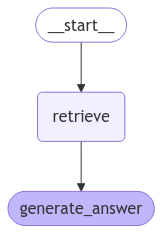

In [10]:
def format_sources_with_id(sources: List[Document]) -> str:
    formatted = [
        f"SOURCE ID: {i}\nContent: {doc.page_content}"
        for i, doc in enumerate(sources)
    ]
    return "\n\n" + "\n---\n".join(formatted)

class Citation(BaseModel):
    source_id: int = Field(
        ...,
        description="The integer ID of a SPECIFIC source which justifies the answer.",
    )
    quote: str = Field(
        ...,
        description="The VERBATIM quote from the specified source that justifies the answer.",
    )


class QuotedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""

    answer: str = Field(
        ...,
        description="The answer to the user question, which is based only on the given sources.",
    )
    citations: List[Citation] = Field(
        ..., description="Citations from the given sources that justify the answer."
    )
    
class State(TypedDict):
    question: str
    context: List[Document]
    answer: QuotedAnswer

def retrieve(state: State):
    retriever.search_kwargs = {"k": 3}
    retrieved_sources = retriever.invoke(state["question"])
    return {"context": retrieved_sources}

def generate_answer(state: State):
    formatted_sources = format_sources_with_id(state["context"])
    messages = generate_prompt.invoke({"question": state["question"], "sources": formatted_sources})
    structured_llm = llm.with_structured_output(QuotedAnswer)
    response = structured_llm.invoke(messages)
    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate_answer])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
def process_final_answer(result) -> str:
    final_answer = result['answer'].answer
    citations = result['answer'].citations
    context = result['context']

    # Process citations
    citation_processor = CitationProcessor(citations=citations, context=context)
    processed_citations = citation_processor.process_citations()

    # Format the sources
    formatted_sources = "\n".join(f"{idx}: {url}" for idx, url in processed_citations['final_urls_dict'].items())

    return final_answer, formatted_sources

In [12]:
result = graph.invoke({"question": "What are different ways to calculate GDP? Please explain them as well."})

In [13]:
result['answer']

QuotedAnswer(answer='There are three different ways to calculate GDP: the production-based method, the expenditure-based method, and the income-based method. The production-based method calculates GDP by measuring the gross value added from production, which means the total value of goods and services produced minus the cost of inputs used in production to avoid double-counting. The expenditure-based method calculates GDP by looking at what is spent on the acquisition of final products and services within a specific time. The income-based method calculates GDP by adding up all the income earned by households in a year, including wages, rent, and interest.', citations=[Citation(source_id=1, quote='The production-based method calculates GDP by measuring the gross value added from production.'), Citation(source_id=1, quote='The expenditure-based method calculates GDP by looking at what is spent on the acquisition of final products and services within a specific time.'), Citation(source_id

In [14]:
final_answer, formatted_sources = process_final_answer(result)
print(final_answer)
print(formatted_sources)

There are three different ways to calculate GDP: the production-based method, the expenditure-based method, and the income-based method. The production-based method calculates GDP by measuring the gross value added from production, which means the total value of goods and services produced minus the cost of inputs used in production to avoid double-counting. The expenditure-based method calculates GDP by looking at what is spent on the acquisition of final products and services within a specific time. The income-based method calculates GDP by adding up all the income earned by households in a year, including wages, rent, and interest.
0: https://rise.articulate.com/share/x4kLM8ubXkKXbaSIIYxdg2lUAat8jkZA#/lessons/yDY_9938GpffmDkf3gJF4au8EIJejfRW/block/clh5bei5k000n3n6u58395476


In [15]:
result = graph.invoke({"question": "In NZ what gases emission should be reported?"})

In [16]:
result['answer']

QuotedAnswer(answer='In New Zealand, the following greenhouse gases emissions should be reported: Carbon dioxide (CO2), Methane (CH4), Nitrous oxide (N2O), Hydrofluorocarbons (HFCs), Perfluorocarbons (PFCs), Sulphur hexafluoride (SF6), and Nitrogen trifluoride (NF3).', citations=[Citation(source_id=0, quote='The greenhouse gases that are required for reporting are:'), Citation(source_id=0, quote='* Carbon dioxide (CO2). * Methane (CH4). * Nitrous oxide (N2O). * Hydrofluorocarbons (HFCs). * Perfluorocarbons (PFCs). * Sulphur hexafluoride (SF6). * Nitrogen trifluoride (NF3).')])

In [17]:
final_answer, formatted_sources = process_final_answer(result)
print(final_answer)
print(formatted_sources)

In New Zealand, the following greenhouse gases emissions should be reported: Carbon dioxide (CO2), Methane (CH4), Nitrous oxide (N2O), Hydrofluorocarbons (HFCs), Perfluorocarbons (PFCs), Sulphur hexafluoride (SF6), and Nitrogen trifluoride (NF3).
0: https://rise.articulate.com/share/-45lAOPCrNAZuyFOPHNQPqUXd32Lb236#/lessons/7s54CktDdO1NbrUpN33xHUEzwVFHQ08w/block/cli7znhds009b3n6op40lj1b3
1: https://rise.articulate.com/share/-45lAOPCrNAZuyFOPHNQPqUXd32Lb236#/lessons/7s54CktDdO1NbrUpN33xHUEzwVFHQ08w/block/cli7znw7h009j3n6o9z62z84g
